# Linear Model with Lexicon Term Frequencies

In [3]:
import os
import re
import pathlib
import warnings
warnings.filterwarnings(action="ignore")

import pprint
import itertools
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def annotateBars(ax, fmt="{:.0f}", percent=False): 
    for p in ax.patches:
        value = p.get_height()
        if percent:
            value = f"{value * 100:.0f}%"
        else:
            value = fmt.format(value)
            
        ax.annotate(value, 
                    (p.get_x() + p.get_width() / 2., 0),
                    ha='center', va='center', fontsize=22, color='black', xytext=(0, 20), textcoords='offset points')
        
def pretty_plot(ax, title, xlab, ylab, sizes=(18, 14, 13)):
    ax.set_title(title, fontsize=sizes[0], y=1.01)
    ax.set_xlabel(xlab, fontsize=sizes[1])
    ax.set_ylabel(ylab, fontsize=sizes[1])

    ax.tick_params(axis="x", labelsize=sizes[2])
    ax.tick_params(axis="x", labelsize=sizes[2])

### I want to predict the society label for peaceful and nonpeaceful countries using the frequencies of the words in the lexicons.

## Prep Data

In [5]:
word_counts = pd.read_csv("../data/word_counts_by_article_NO_OTHER.csv")
lexicon = pd.read_csv("../lexicons/lexicon.csv")

lexicon = lexicon[lexicon.lexicon != "resilience"].copy()

In [6]:
print(word_counts.shape)

use_cols = [c for c in word_counts.columns if c in lexicon.term.unique()] + [c for c in word_counts.columns[-3:]]
word_counts = word_counts[use_cols]

print(word_counts.shape)

(822988, 2057)
(822988, 1796)


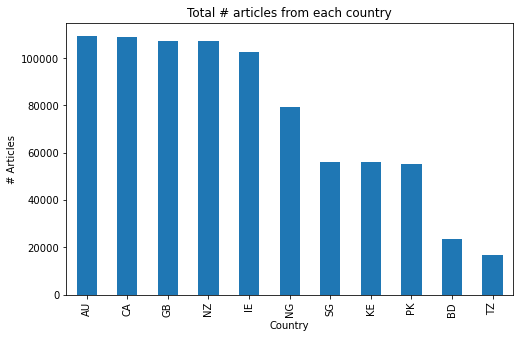

In [7]:
word_counts.country.value_counts().plot(kind="bar", figsize=(8, 5),
                                        title="Total # articles from each country", 
                                        xlabel="Country", ylabel="# Articles");

I randomly sample 75,000 articles from each society, where each country has the same number of articles.

In [8]:
resample = []

N = 75_000
for society, society_df in word_counts.groupby("society"):
    num_countries = society_df.country.unique().shape[0]
    num_to_sample = int(np.floor(N / num_countries))
    
    for country, country_df in tqdm(society_df.groupby("country"), desc=f"Getting sample for {society.upper()}"):
        if country_df.shape[0] >= num_to_sample:
            df = country_df.sample(num_to_sample, random_state=2020)
        else:
            df = country_df
            
        resample.append(df)

del word_counts
word_counts = pd.concat(resample)

Getting sample for PEACEFUL: 100%|███████████████████████████████████████████████████████| 6/6 [00:19<00:00,  3.21s/it]


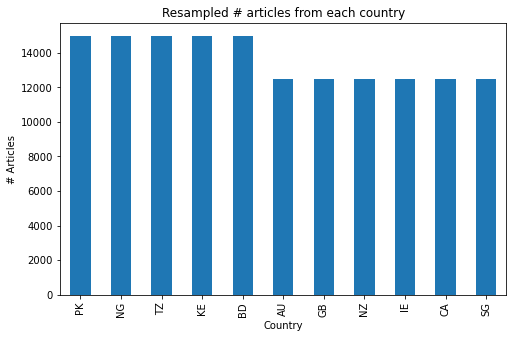

In [9]:
word_counts.country.value_counts().plot(kind="bar", figsize=(8, 5),
                                        title="Resampled # articles from each country", 
                                        xlabel="Country", ylabel="# Articles");

The data is in a wide format already, with each column being a word and each row is an article. The values are the counts of that word in that article.

In [10]:
print(word_counts.shape)
word_counts.head()

(150000, 1796)


,academic freedom,acceptance,accepting,active listening,activism,advocate,agree,agreed,agreeing,agreement,...,commit,participate,successful,understand,immediate,adopt,amend,society,country,year
121240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Nonpeaceful,BD,2013
116714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Nonpeaceful,BD,2012
127724,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,Nonpeaceful,BD,2011
122645,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,Nonpeaceful,BD,2014
129808,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Nonpeaceful,BD,2020


In [11]:
X = word_counts.iloc[:, :-3]
y = word_counts.iloc[:, -3]

In [12]:
X.to_csv("LR Sampled X.csv")
y.to_csv("LR Sampled y.csv")

In [13]:
del word_counts

#### To speed things up, I am going to drop the words that do not appear often (if ever) in the sample. Also, the word must be at least 3 characters long.

In [11]:
X_tot_word_counts = X.stack().reset_index()
X_tot_word_counts.columns = ["article", "term", "n"]
X_tot_word_counts = X_tot_word_counts.groupby("term")

n = X_tot_word_counts.n.sum().rename("n").reset_index().set_index("term")
n_articles = X_tot_word_counts.n.apply(lambda x: (x > 0).sum()).rename("n_articles").reset_index().set_index("term")

X_tot_word_counts = n.join(n_articles).reset_index()
X_tot_word_counts = X_tot_word_counts[X_tot_word_counts.term.str.len() > 2]

Let's quickly visualize how many words might be worth dropping.

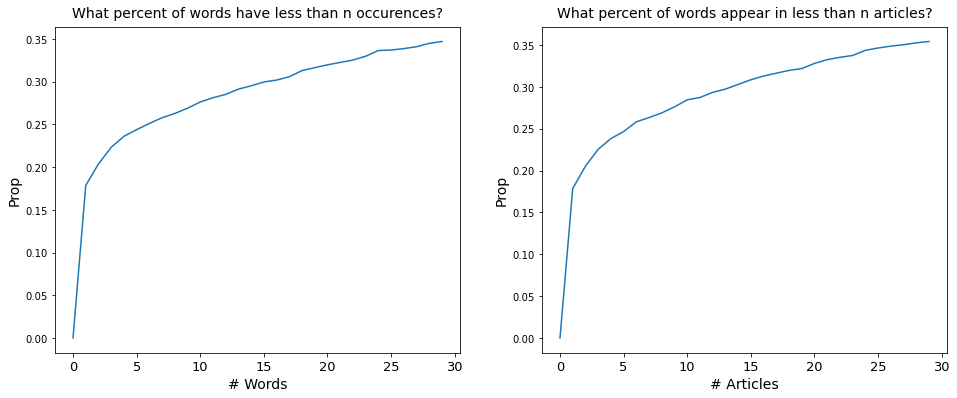

In [12]:
def get_pct_lt_n_words(x):
    return X_tot_word_counts[X_tot_word_counts.n < x].shape[0] / X.shape[1]

def get_pct_lt_n_articles(x):
    return X_tot_word_counts[X_tot_word_counts.n_articles < x].shape[0] / X.shape[1]

xs = np.arange(0, 30)
ns = [get_pct_lt_n_words(n) for n in xs]
n_articles = [get_pct_lt_n_articles(n) for n in xs]

fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
sns.lineplot(xs, ns, ax=axes[0])
pretty_plot(axes[0], "What percent of words have less than n occurences?", "# Words", "Prop", sizes=(14, 14, 13))

sns.lineplot(xs, n_articles, ax=axes[1])
pretty_plot(axes[1], "What percent of words appear in less than n articles?", "# Articles", "Prop", sizes=(14, 14, 13))

Arbitrarily, I am going with words must appear in atleast 5 articles.

In [13]:
pct = get_pct_lt_n_articles(5)
print(f"{pct * 100:.1f}%")

24.7%


What is getting removed?

In [14]:
pp = pprint.PrettyPrinter(compact=True, width=100)

X_tot_word_counts_ = X_tot_word_counts.merge(lexicon, on="term")[["version", "lexicon", "term", "n", "n_articles"]]
for g, df in X_tot_word_counts_[X_tot_word_counts_.n_articles < 5].groupby(["version", "lexicon"]):
    print(" ".join(g).title())
    if df.empty:
        print(set())
    else:
        pp.pprint(set(df.term.tolist()))
    print()

Original Conflict
{'aborted state', 'aching', 'adversant', 'adversative', 'adversatively', 'adverseness', 'afflicter',
 'afflicting', 'aggravating factors', 'aggravator', 'ak-47', 'anarchic state', 'anarchical',
 'anarchism', 'anarchize', 'annihilative', 'annihilator', 'antagonization', 'antagonizer',
 'argumentation', 'argumentatively', 'argumentativeness', 'armed combat', 'assassinative',
 'assassinator', 'assaultable', 'attackable', 'aversive racism', 'bad feelings', 'battleful',
 'beheader', 'bioattack', 'breachful', 'childhood punishment', 'closed economy',
 'coercive diplomacy', 'coercively', 'coerciveness', 'coercivity', 'collective guilt',
 'collective violence', 'collisive', 'combatable', 'combater', 'combats', "coup d'etat",
 'cyber-terrorism', 'cyberwar', 'deathblow', 'decapitator', 'decimator', 'decollate',
 'depressively', 'depressiveness', 'destroyable', 'destructively', 'destructiveness',
 'destructivity', 'detractors', 'devastative', 'devastator', 'discordance', 'discor

How much data did I remove?

In [15]:
print("Old X shape", X.shape)
X_ = X[X_tot_word_counts[X_tot_word_counts.n_articles >= 5].term]
print("New X shape", X_.shape)

Old X shape (150000, 1793)
New X shape (150000, 1351)


In [16]:
final_terms = X_.columns

## Begin Modeling

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

from sklearn.model_selection import GridSearchCV

### Model Selection

I train a Logistic Regression and Random Forest with 10 fold cross-validation to selct the model.

In [24]:
# del word_counts
del X

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, stratify=y, random_state=116)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test",  X_test.shape)
print("y_test",  y_test.shape)

X_train (112500, 1351)
y_train (112500,)
X_test (37500, 1351)
y_test (37500,)


In [26]:
y_train.value_counts()

Peaceful       56250
Nonpeaceful    56250
Name: society, dtype: int64

#### Validate logistic regression will work

In [34]:
pipeline = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('scale', StandardScaler(with_mean=False)),
    ('model', DummyClassifier())
])

grid = {
    "model": [
        DummyClassifier(),
        LogisticRegressionCV(penalty='l1', solver='liblinear'),
        RandomForestClassifier()
    ]
}

gs = GridSearchCV(pipeline, grid, cv=10, scoring=["accuracy", "f1"], n_jobs=4, verbose=100, return_train_score=True, refit="f1")
gs.fit(X_train, y_train == "Peaceful");

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   23.3s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   23.8s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   24.0s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   24.3s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   33.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   35.0s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(

In [112]:
def tidy_cv_result(cv_result, split_type, metric="score", nfolds=10):
    regex = r"split[\d]+_{:}_{:}".format(split_type, metric)
    cols = ["param_model"] + [c for c in cv_result.columns if re.match(regex, c)]
    res = cv_result[cols]
    res.columns = ["model"] + [str(i) for i in range(nfolds)]
    res["model"] = res.model.astype(str) #.str.extract(r"(\w+)\(*")
    res = res.set_index("model").stack(dropna=False).reset_index()
    res.columns = ["model", "split", "score"]
    res["metric"] = metric
    res["split_type"] = split_type
    
    return res[["model", "metric", "split_type", "split", "score"]]

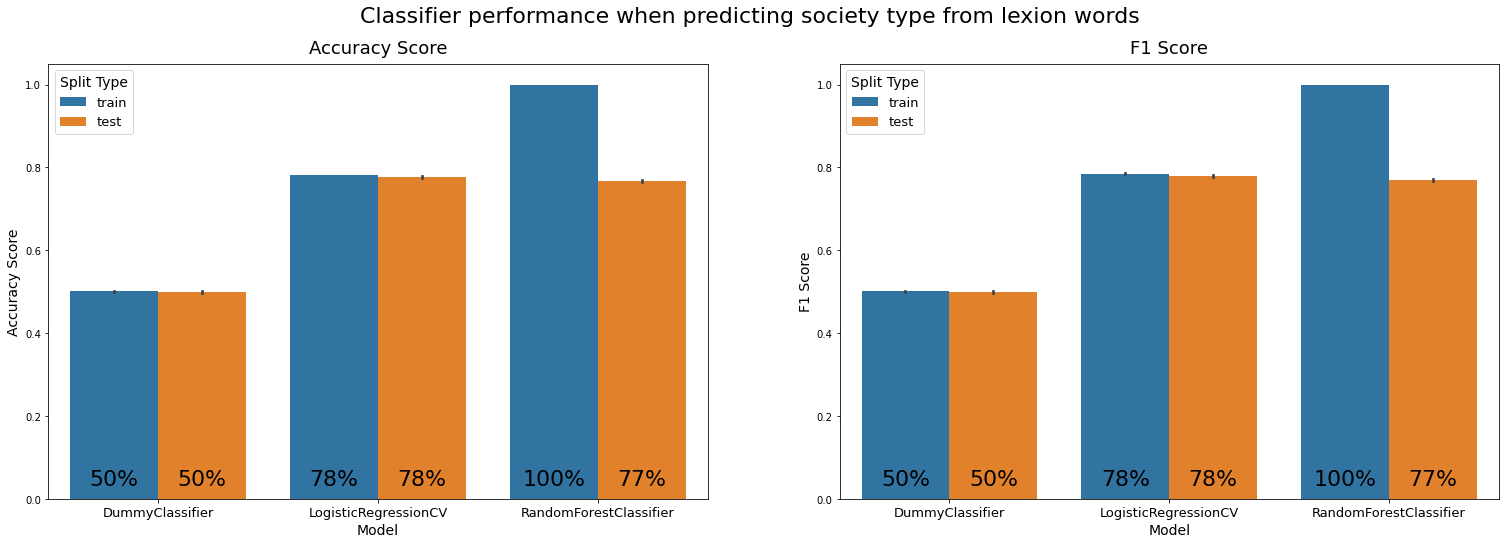

In [36]:
res = pd.DataFrame(gs.cv_results_)

res_acc = pd.concat([
    tidy_cv_result(res, "train", "accuracy"),
    tidy_cv_result(res, "test",  "accuracy"),
])

res_f1 = pd.concat([
    tidy_cv_result(res, "train", "f1"),
    tidy_cv_result(res, "test",  "f1"),
])

fig, axes = plt.subplots(ncols=2, figsize=(26, 8))
title = "Classifier performance when predicting society type from lexion words"

sns.barplot(x="model", y="score", hue="split_type", data=res_acc, ax=axes[0])
pretty_plot(axes[0], "Accuracy Score", "Model", "Accuracy Score")
annotateBars(axes[0], percent=True)

legend = axes[0].legend(title="Split Type", loc="upper left", fontsize=13)
legend.get_title().set_fontsize(14)

sns.barplot(x="model", y="score", hue="split_type", data=res_f1, ax=axes[1])
pretty_plot(axes[1], "F1 Score", "Model", "F1 Score")
annotateBars(axes[1], percent=True)

legend = axes[1].legend(title="Split Type", loc="upper left", fontsize=13)
legend.get_title().set_fontsize(14)

plt.suptitle(title, fontsize=22);

In [95]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer

identity_transformer = FunctionTransformer(lambda x: x)

def get_lexicon(allowed, lexicon, versions):
    if isinstance(versions, str) and versions.lower() == "all":
        terms = lexicon.term.unique()
    else:
        if isinstance(versions, str):
            terms = lexicon[lexicon.version == versions].term.unique()
        else:
            terms = lexicon[lexicon.version.isin(versions)].term.unique()
            
    return [t for t in terms if t in allowed]

def column_selector(allowed, lexicon, versions):
    if isinstance(versions, list):
        transformer_name = ",".join(versions)
    else:
        transformer_name = versions
        
    return ColumnTransformer([
        (transformer_name, identity_transformer, get_lexicon(allowed, lexicon, versions)),
    ], remainder="drop")

pipeline = Pipeline([
    ('select', column_selector(X_train.columns, lexicon, "all")),
    ('tfidf', TfidfTransformer()),
    ('scale', StandardScaler(with_mean=False)),
    ('model', LogisticRegressionCV(penalty='l1', solver='liblinear'))
])

grid = {
    "select": [
        column_selector(X_train.columns, lexicon, "All"),
        column_selector(X_train.columns, lexicon, "Original"),
        column_selector(X_train.columns, lexicon, "Term Frequency"),
        column_selector(X_train.columns, lexicon, "Attention Layer"),
        column_selector(X_train.columns, lexicon, ["Term Frequency", "Attention Layer"])
    ]
}

gs = GridSearchCV(pipeline, grid, cv=10, scoring="accuracy", n_jobs=4, verbose=100, return_train_score=True)
gs.fit(X_train, y_train == "Peaceful");

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  3.4min
[Parallel(

In [96]:
def get_label(x):
    return {
        "All": "All Version",
        "Original": "OG Alone", 
        "Term Frequency": "TF Alone",
        "Attention Layer": "AL Alone",
        "Term Frequency,Attention Layer": "TF + AL"
    }[x]

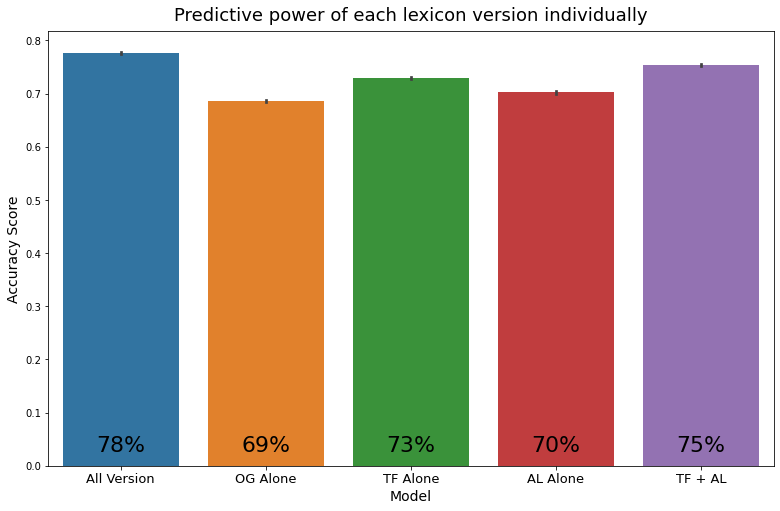

In [114]:
res = pd.DataFrame(gs.cv_results_)
res["param_model"] = res["param_select"].apply(lambda x: get_label(x.transformers[0][0]))

res_tidy = pd.concat([
    tidy_cv_result(res, "test"),
])

fig, ax = plt.subplots(figsize=(13, 8))

sns.barplot(x="model", y="score", data=res_tidy, ax=ax)
pretty_plot(ax, "Predictive power of each lexicon version individually", "Model", "Accuracy Score")
annotateBars(ax, percent=True)

### Model Evaluation

In [116]:
pipeline = Pipeline([
    ('select', column_selector(X_train.columns, lexicon, ["Term Frequency", "Attention Layer"])),
    ('tfidf', TfidfTransformer()),
    ('scale', StandardScaler(with_mean=False)),
    ('model', LogisticRegressionCV(penalty='l1', solver='liblinear'))
])

pipeline.fit(X_train, y_train);
lr_fit = pipeline.named_steps["model"]

In [123]:
terms = pd.Series(get_lexicon(X_train.columns, lexicon, ["Term Frequency", "Attention Layer"])).rename("term")

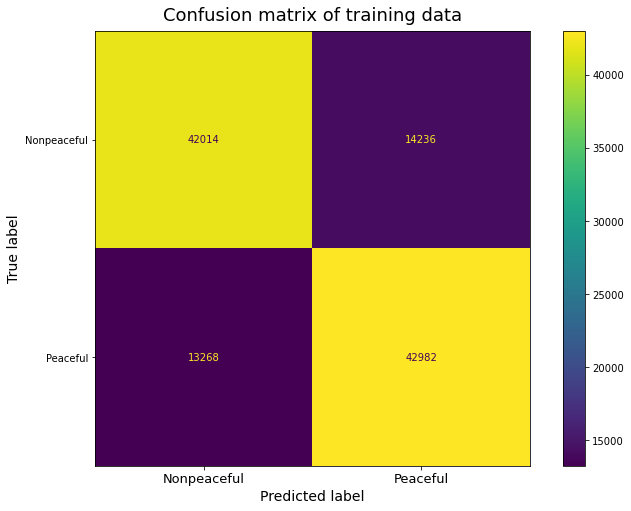

In [117]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(12, 8))
pretty_plot(ax, "Confusion matrix of training data", "Predicted Label", "True Label")
plot_confusion_matrix(pipeline, X_train, y_train, ax=ax);

In [118]:
lexicon_simple = lexicon[["lexicon", "term" , "version"]]
lexicon_simple["present"] = True
lexicon_simple = lexicon_simple.pivot(
    index=["lexicon", "term"], 
    columns="version", 
    values="present"
).reset_index().replace(np.nan, False)

def get_lexicon_version(row):
    orig = row["Original"]
    tf = row["Term Frequency"]
    atten = row["Attention Layer"]
    
    if all([orig, tf, atten]):
        return "Original"
    elif tf:
        return "Term Frequency"
    elif atten:
        return "Attention Layer"
    
    return "Original"

lexicon_simple["version"] = lexicon_simple.apply(get_lexicon_version, axis=1)
lexicon_simple = lexicon_simple[["lexicon", "version", "term"]]
lexicon_simple

version,lexicon,version,term
0,conflict,Original,aborted state
1,conflict,Original,absolute poverty
2,conflict,Term Frequency,access
3,conflict,Term Frequency,accord
4,conflict,Attention Layer,according
...,...,...,...
1890,peace,Original,women’s international league for peace and fre...
1891,peace,Original,world federation
1892,peace,Original,world governance
1893,peace,Original,worship


In [134]:
term_coef = pd.DataFrame(
    np.column_stack([
        terms,
        lr_fit.coef_.reshape(-1)
    ]), columns=["term", "coef"]
)

term_coef = term_coef.merge(
    lexicon_simple, 
    on="term", 
    how="left"
)

colors = {
    "peace": "#6db7f7", 
    "resilience": "#36CB8A", 
    "conflict": "#FF5A59"
}

term_coef["coef"] = term_coef["coef"].astype(float)
term_coef["abs_coef"] = np.abs(term_coef.coef)
term_coef["sign_coef"] = term_coef.coef.apply(lambda x: "POS" if np.sign(x) > 0 else "NEG")
term_coef["importance_rank"] = term_coef.abs_coef.rank(method="min", ascending=False)
term_coef["bar_color"] = term_coef.lexicon.apply(lambda x: colors[x])

# term_coef = term_coef.drop_duplicates("term", keep=False)
# term_coef = term_coef[term_coef.term.str.len() > 3]
term_coef = term_coef[term_coef.version != "Original"]
term_coef = term_coef.sort_values("abs_coef", ascending=False)

term_coef[["version", "lexicon", "term", "coef"]].to_csv("../data/LR_term_coef.csv", index=False)

print(term_coef.shape)
term_coef.head()

(366, 8)


,term,coef,lexicon,version,abs_coef,sign_coef,importance_rank,bar_color
299,new,0.298324,conflict,Attention Layer,0.298324,POS,1.0,#FF5A59
103,state,-0.216257,conflict,Term Frequency,0.216257,NEG,2.0,#FF5A59
107,accord,-0.190634,conflict,Term Frequency,0.190634,NEG,3.0,#FF5A59
4,really,0.180100,peace,Term Frequency,0.180100,POS,4.0,#6db7f7
1,think,0.156943,peace,Term Frequency,0.156943,POS,5.0,#6db7f7


### FOR EASE, terms that apper in multiple lexicons are removed. If a term appears in multiple versions, the original is the default.

do any coefficients go to 0, what lexicons are they coming from?

In [136]:
term_coef[term_coef.coef == 0].groupby(["version", "lexicon"]).size()

Series([], dtype: int64)

What are these words?

In [137]:
pp = pprint.PrettyPrinter(compact=True, width=100)

for g, df in term_coef[term_coef.coef == 0].groupby(["version", "lexicon"]):
    print(" ".join(g).upper())
    pp.pprint(set(df.term.tolist()))
    print()

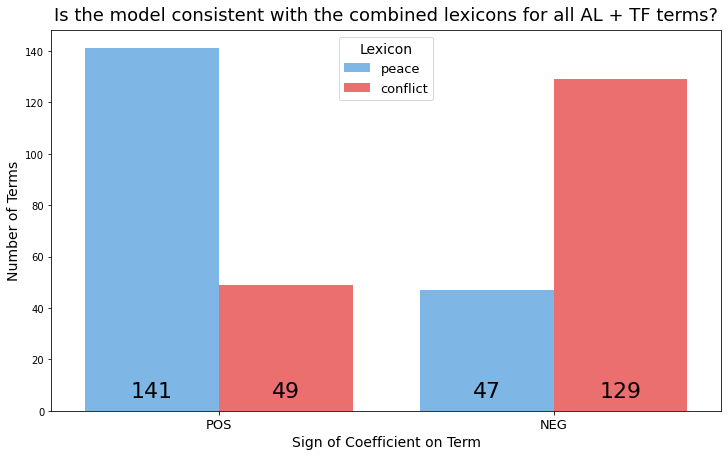

In [138]:
lexicon_consistency = term_coef.sort_values("abs_coef", ascending=False).head(500)
lexicon_consistency = lexicon_consistency.groupby(["sign_coef", "lexicon"]).size().rename("n").reset_index()
lexicon_consistency = lexicon_consistency.sort_values(["sign_coef", "n"], ascending=False)
lexicon_consistency["bar_color"] = lexicon_consistency.lexicon.apply(lambda x: colors[x])

fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(
    x="sign_coef", 
    y="n",
    hue="lexicon",
    palette=lexicon_consistency.bar_color,
    data=lexicon_consistency
)

title = "Is the model consistent with the combined lexicons for all AL + TF terms?"
pretty_plot(ax, title, "Sign of Coefficient on Term", "Number of Terms")

legend = plt.legend(title="Lexicon", loc="upper center", fontsize=13)
legend.get_title().set_fontsize(14)

annotateBars(ax)

For the top 500 terms from the logistic regression model, we see that the vast majority of terms with a positive coefficient are from the peace lexicon, and similarly the terms with negative coefficients are mostly from the conflict lexicon. This seems to imply that our lexicons are doing a good job of separating the two types of countries. For this model, positive coefficients increase the probability of being a 'peaceful' country, so it looks like our peaceful terms drive the probability up while conflict terms tend to drive it down. It is also interesting that the resillience lexicon appears evenly in both groups.

Next are some actual words and how their pressence drives the probability of being a peaceful nation. The bars are colored by lexicon, so that we see the trend discussed above. 

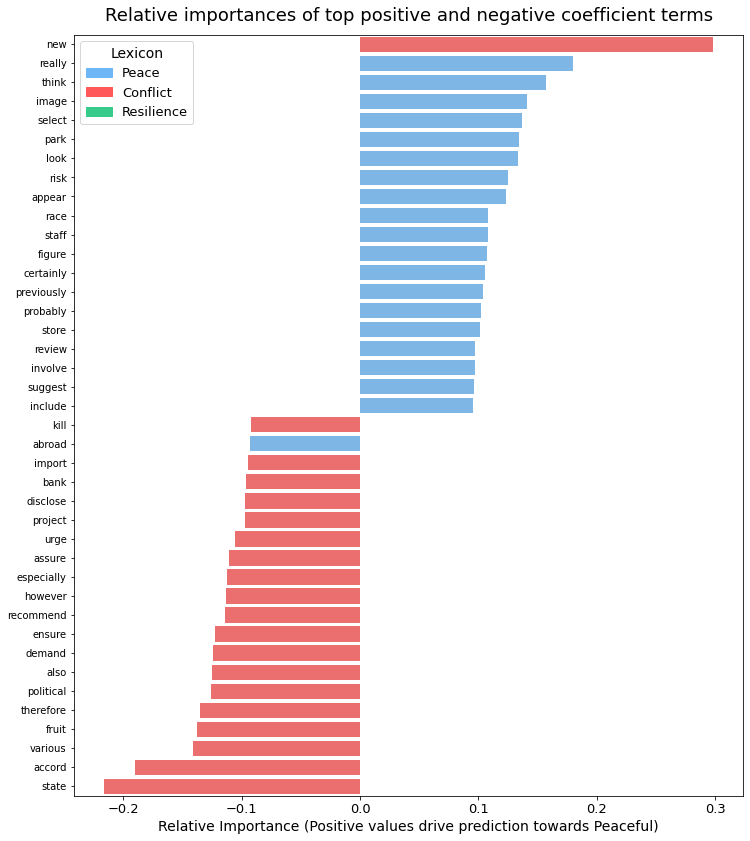

In [139]:
top_coef = term_coef.groupby("sign_coef").apply(lambda x: x.nlargest(20, ['abs_coef'])).reset_index(drop=True)
top_coef = top_coef.sort_values("coef", ascending=False)

fig, ax = plt.subplots(figsize=(12, 14))
sns.barplot(x="coef", y="term", palette=top_coef.bar_color, data=top_coef, ax=ax)

title = "Relative importances of top positive and negative coefficient terms"
xlab = "Relative Importance (Positive values drive prediction towards Peaceful)"

labels = ["Peace", "Conflict", "Resilience"]
handles = [plt.Rectangle((0,0),1,1, color=colors[label.lower()]) for label in labels]
           
legend = plt.legend(handles, labels, title="Lexicon", loc="upper left", fontsize=13)
legend.get_title().set_fontsize(14)

pretty_plot(ax, title, xlab, None)

I don't know. My takeaway here is that terms in the new lexicon tend to have much larger coefficients than terms from the old lexicon.

In [48]:
pipeline.score(X_test, y_test)

0.77576